In [1]:
import os, argparse, pickle, librosa
from scipy.io.wavfile import write
import matplotlib.pyplot as plt
import torch
from glob import glob
from utils import *
import models
import IPython.display as ipd

In [2]:
args = argparse.ArgumentParser()
args.add_argument('--gpus', type=str, default='0')
args.add_argument('--batch', type=int, default=1)
args.add_argument('--len', type=int, default=40)
args.add_argument('--b', type=int, default=40)
args.add_argument('--mode', type=str, default='sj_S')
args.add_argument('--model', type=str, default='FCAutoencoder')
config = args.parse_known_args()[0]

In [3]:
SR = 8192
WINDOW_SIZE = 500 # us
data_length = config.len
BATCH_SIZE = config.batch
K, m = 8, 8
ls = 128

In [4]:
ABSpath = '/home/skuser/'
path = os.path.join(ABSpath, 'ai_model/pytorch/test_model')
data_path = os.path.join(ABSpath,'data')
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
accel_raw_data = pickle.load(open(os.path.join(data_path,'stationary_accel_data.pickle'),'rb'))
sound_raw_data = pickle.load(open(os.path.join(data_path,'stationary_sound_data.pickle'),'rb'))
transfer_f = np.array(pickle.load(open(os.path.join(data_path,'transfer_f.pickle'),'rb')))
transfer_f = torch.from_numpy(transfer_f).to(device)
transfer_f.requires_grad = False

dataset = makeDataset(accel_raw_data, sound_raw_data, config.b, data_length, False)
name = 'CombineAutoencoder_sj_S_40_40_adam_0.001_decay0.7071/*'
# name = 'FCAutoencoder_sj_S_40_40_adam_0.001_decay0.7071/*'
modelsavepath = sorted(glob(os.path.join(path, 'model_save/'+name)), key=lambda x: float(x.split('.')[0].split('/')[-1].split('_')[-1]))[0]
model = getattr(models, name.split('_')[0])((data_length + config.b) * 12, 40 * 8).to(device)

In [5]:
model.load_state_dict(torch.load(modelsavepath)['model'])
print(modelsavepath)

/home/skuser/ai_model/pytorch/test_model/model_save/CombineAutoencoder_sj_S_40_40_adam_0.001_decay0.7071/52_1.091.pt


In [6]:
dataset_generator = DataLoader(dataset, batch_size=64, shuffle=False)
data_res, sound_res = [], []
model.eval()
with torch.no_grad():
    for data, sound in dataset_generator:
        data_res.append(conv_with_S(model(data.to(device).transpose(1,2)), S_data=transfer_f, device=device).cpu())
        sound_res.append(sound)

In [7]:
from time import time
with torch.no_grad():
    for data, sound in dataset_generator:
        s = time()
        model(data.to(device).transpose(1,2))
        break

In [8]:
data_res = torch.cat(data_res)
sound_res = torch.cat(sound_res)

In [9]:
data_res = torch.reshape(data_res, (-1,data_res.size(-1)))
sound_res = torch.reshape(sound_res, (-1,data_res.size(-1)))

<Figure size 432x288 with 0 Axes>

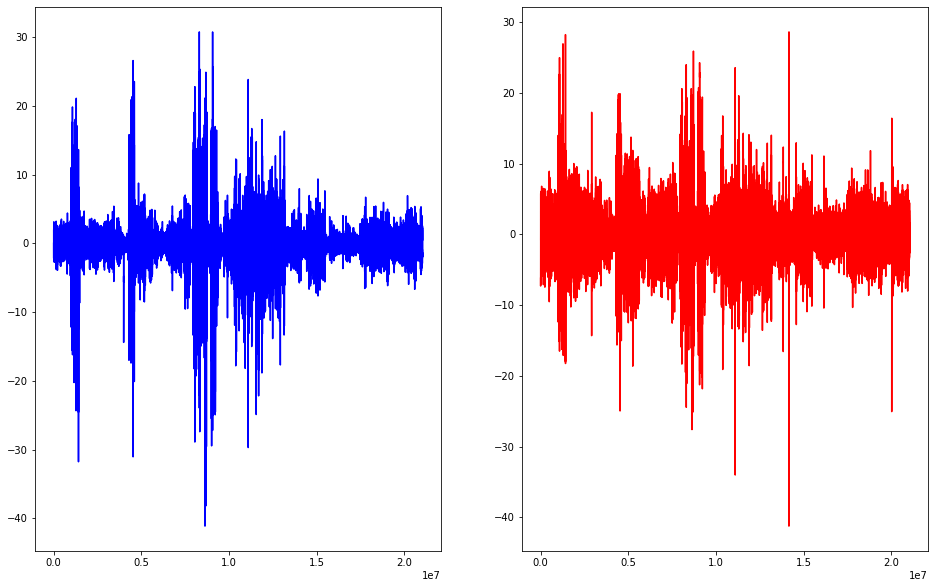

In [10]:
fig = plt.figure()
fig, ax_lst = plt.subplots(1, 2, figsize=(16,10))
ax_lst[0].plot(np.arange(data_res.size(0)), data_res[:,0], color="blue")
ax_lst[1].plot(np.arange(sound_res.size(0)), sound_res[:,0], color="red")
# ax_lst[1].plot(np.arange(data_res.size(0)), data_res[:,1])
# ax_lst[0].plot(np.arange(sound_res.size(0)), data_res[:,1])


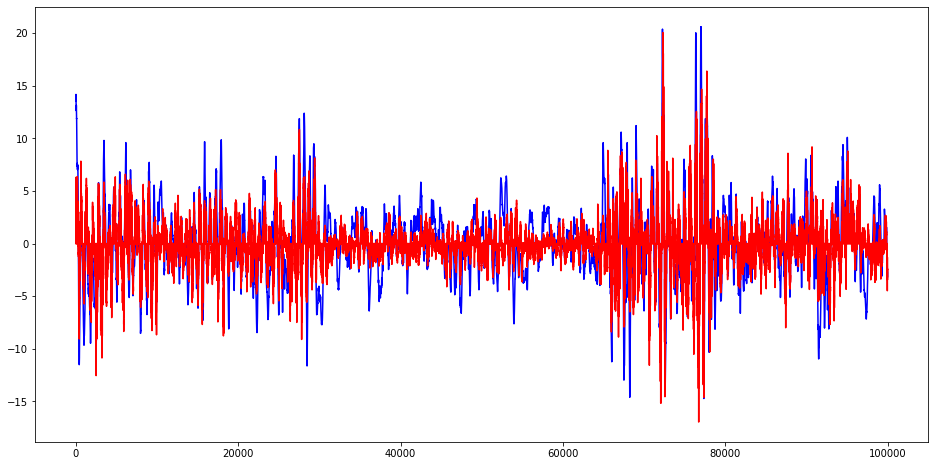

In [11]:
start = 1000000
end = 1100000
fig=plt.figure(figsize=(16,8))
ax = fig.add_subplot()
ax.plot(sound_res[start:end,1], color="blue")
ax.plot(data_res[start:end,1], color="red")
# self.writer.add_figure("Train/Plot", fig, data_res.size(0))
plt.show(fig)

In [12]:
smoo = ema(data_res)

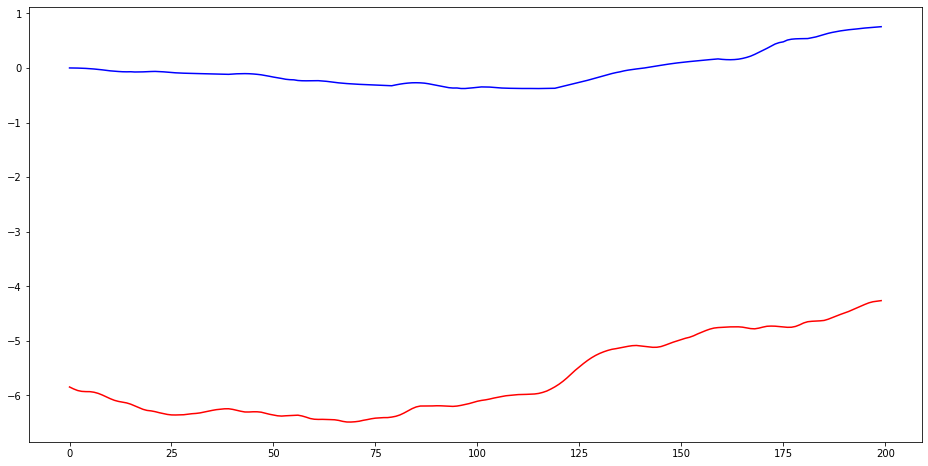

In [13]:
start = 0
end = 200
fig=plt.figure(figsize=(16,8))
ax = fig.add_subplot()
ax.plot(smoo[start:end,1], color="blue")
ax.plot(sound_res[start:end,1], color="red")
plt.show(fig)

In [14]:
dBA_metric(data_res, sound_res, False)

-21.986859516344744

In [15]:
dBA_metric(smoo,sound_res,False)

-3.4233542092721096

In [16]:
dBA_metric(sound_res,smoo,False)

-3.1209276722015415

In [32]:
write_wav(sound_res[1000000:1100000,0] - smoo[1000000:1100000,0],name='smooth')

array([0.70883936, 0.7159476 , 0.7219531 , ..., 0.37632784, 0.37560615,
       0.37524652], dtype=float32)

In [33]:
write_wav(sound_res[1000000:1100000,0], name='sound').shape

(100000,)

In [34]:
ipd.Audio('sound.wav')

In [35]:
ipd.Audio('smooth.wav') # load a local WAV file